# Fid CALDB row/col to yag/zag plate scale update

This notebook inserts the temperature-based coefficients from the updated star plate scale calibration into the fid light calibration.

There is a slight complication in this process of not changing the behavior at T=14C where all the original calibration of fid positions was done.  Therefore the new non-temperature-dependent coefficients are formally different, but evaluate to produce the same answer as the current coefficients at T=14C.


### Plate scale polynomial definition
```
 0 [ones,  
 1 c,     
 2 r, 
 3 t,  <!! Leave at 0
 4 c * c, 
 5 c * r,  
 6 c * t,  <= Temperature
 7 r * r, 
 8 r * t,  <= Temperature
 9 t * t,  <!! Leave at 0
10 c * c * c, 
11 r * c * c,
12 t * c * c,  <= Temperature
13 c * r * r, 
14 c * r * t,  <= Temperature
15 c * t * t,  <= Temperature
16 r * r * r, 
17 t * r * r,  <= Temperature
18 r * t * t,  <= Temperature
19 t * t * t]  <!! Leave at 0
```

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style
matplotlib.style.use('bmh')
import chandra_aca.transform
from Ska.Matplotlib import plot_cxctime
from pathlib import Path
import os

from astropy.table import Table, QTable
from sherpa import ui
from cheta import fetch_sci as fetch

In [212]:
coeffs_star = np.array([[  8.42957944e-03,  -6.84733083e-03],
       [  2.28668273e-06,   1.38775294e-03],
       [ -1.38764910e-03,   2.56622570e-06],
       [  0.00000000e+00,   0.00000000e+00],
       [ -3.82229443e-10,   6.73615941e-10],
       [ -3.05429237e-10,   1.26847499e-09],
       [ -8.08320902e-11,  -3.87108289e-08],
       [ -1.72460168e-09,   3.48433477e-10],
       [  4.29962197e-08,  -3.27306346e-08],
       [  0.00000000e+00,   0.00000000e+00],
       [  1.52372188e-13,  -3.35659348e-11],
       [  3.25013419e-11,  -9.24719963e-14],
       [  3.29594704e-12,  -1.45179660e-12],
       [ -4.09086386e-14,  -3.26006583e-11],
       [ -1.46631941e-12,  -1.67374074e-12],
       [  1.43836754e-11,  -8.59453813e-11],
       [  3.29480263e-11,  -9.39471279e-14],
       [ -1.06374265e-12,   2.72769013e-12],
       [ -1.07588256e-10,   1.09572478e-09]])

In [217]:
def reparametrize_coeffs(coeffs, t0):
    out = coeffs.copy()
    for ii in range(2):
        a = out[:, ii]
        a[1] += a[6] * t0 + a[15] * t0**2
        a[2] += a[8] * t0 + a[18] * t0**2
        a[4] += a[12] * t0
        a[5] += a[14] * t0
        a[6] += a[15] * 2 * t0
        a[7] += a[17] * t0
        a[8] += a[18] * 2 * t0
    return out

In [214]:
def dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [215]:
# Slimmed down version of code in chandra_aca.transform that requires
# passing in the coefficients.

def pixels_to_yagzag(row, col, coeff, t_aca=20):
    """
    Convert ACA row/column positions to ACA y-angle, z-angle.
    It is expected that the row and column input arguments have the same length.

    The ``pix_zero_loc`` parameter controls whether the input pixel values
    are assumed to have integral values at the pixel center or at the pixel
    lower/left edge.  The PEA flight coefficients assume lower/left edge, and
    that is the default.  However, it is generally more convenient when doing
    centroids and other manipulations to use the center.

    :param row: ACA pixel row (single value, list, or 1-d numpy array)
    :param col: ACA pixel column (single value, list, or 1-d numpy array)
    :param coeffs: 19 x 2 array of transform coefficients
    :param t_aca: ACA temperature (degC) for use with flight (default=20C)
    :param pix_zero_loc: row/col coords are integral at 'edge' or 'center'
    :rtype: (yang, zang) each vector of the same length as row/col
    """
    from chandra_aca.transform import _poly_convert
    
    row = np.asarray(row)
    col = np.asarray(col)

    ydeg, zdeg = _poly_convert(row, col, coeff, t_aca)

    # Convert to arcsecs from degrees
    return 3600 * ydeg, 3600 * zdeg

In [216]:
# Slimmed down version of code in chandra_aca.transform that requires
# passing in the coefficients.

def yagzag_to_pixels(yang, zang, coeff, t_aca=20):
    """
    Convert ACA y-angle/z-angle positions to ACA pixel row, column.
    It is expected that the y-angle/z-angle input arguments have the same length.

    The ``pix_zero_loc`` parameter controls whether the input pixel values
    are assumed to have integral values at the pixel center or at the pixel
    lower/left edge.  The PEA flight coefficients assume lower/left edge, and
    that is the default.  However, it is generally more convenient when doing
    centroids and other manipulations to use ``pix_zero_loc='center'``.

    :param yang: ACA y-angle (single value, list, or 1-d numpy array)
    :param zang: ACA z-angle (single value, list, or 1-d numpy array)
    :param allow_bad: boolean switch.  If true, method will not throw errors
                         if the resulting row/col values are nominally off the ACA CCD.
    :param pix_zero_loc: row/col coords are integral at 'edge' or 'center'
    :rtype: (row, col) each vector of the same length as row/col    
    """
    from chandra_aca.transform import _poly_convert
    
    yang = np.array(yang)
    zang = np.array(zang)
    row, col = _poly_convert(yang, zang, coeff, t_aca=t_aca)

    return row, col

In [218]:
# Field distortion coefficients CALDB file aka "flight" calibration
fdc_file = Path(os.environ['SKA'], 'ops', 'CALDB', 'data', 'chandra', 
                'pcad', 'fdc', 'acapD1999-07-22fdcN0003.fits')
fdc = Table.read(fdc_file)

In [219]:
fdc.colnames

['fd_y_star',
 'fd_z_star',
 'fd_y_fid',
 'fd_z_fid',
 'fd_r_star',
 'fd_c_star',
 'fd_r_fid',
 'fd_c_fid']

In [232]:
# Flight coefficients have different pixel_zero_location than on-board, so fix here.
# Chandra_aca.pixels_to_yagzag requires the following adjustment.  I don't precisely
# understand why the zag term is -2.5 instead of +2.5 but this works.
coeffs_caldb = np.array([fdc['fd_y_fid'][0], fdc['fd_z_fid'][0]]).transpose()
# coeffs_caldb[0, :] += [2.5 / 3600, -2.5 / 3600]
coeffs_caldb = coeffs_caldb[:19]

In [233]:
# Low-order coefficients in current ground calibration
coeffs_caldb[:6, :] * 3600

array([[  3.26079788e+01,  -1.52080593e+01],
       [  9.78699606e-03,   4.99532366e+00],
       [ -4.99806023e+00,   6.79658400e-03],
       [  0.00000000e+00,   0.00000000e+00],
       [ -3.50355231e-06,   2.52292693e-06],
       [ -3.68150381e-06,  -5.43232829e-07]], dtype=float32)

In [234]:
# Compare to low-order flight coeffs in EEPROM
coeffs_pea = np.rad2deg(chandra_aca.transform.PIX2ACA_eeprom)
coeffs_pea[:6, :] * 3600

array([[  3.03464844e+01,  -2.46503906e+01],
       [  9.38110352e-03,   4.99642792e+00],
       [ -4.99528198e+00,   9.14611816e-03],
       [  0.00000000e+00,   0.00000000e+00],
       [ -1.14440918e-06,   2.53915787e-06],
       [ -1.19805336e-06,   3.72529030e-06]])

In [235]:
# Reparametrize in terms of (T - 14C) so that thermal-based coefficients are
# zero at 14C.
coeffs_new_14 = reparametrize_coeffs(coeffs_caldb, 14)
coeffs_star_14 = reparametrize_coeffs(coeffs_star, 14)

In [236]:
# Copy the star thermal coefficients and then reparametrize back to T (not (T - 14))
t_par_idxs = [6, 8, 12, 14, 15, 17, 18]
for idx in t_par_idxs:
    coeffs_new_14[idx, :] = coeffs_star_14[idx, :]
coeffs_new = reparametrize_coeffs(coeffs_new_14, -14)

In [237]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    norm = np.linalg.norm(vector)
    return vector / norm, norm

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [13]:
def get_angles(yags1, zags1, yags2, zags2):
    angles = []
    for yag2, zag2, yag1, zag1 in zip(yags2.flat, zags2.flat, 
                                      yags1.flat, zags1.flat):
        v1 = np.array([yag2, zag2])
        v2 = np.array([yag1, zag1])
        v1_u, norm1 = unit_vector(v1)
        v2_u, norm2 = unit_vector(v2)
        if norm1 > 500:
            angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
            angles.append(np.rad2deg(angle) * 3600)  # arcsec
    return np.array(angles)

In [14]:
def compare_coeffs_dashboard(coeffs1, coeffs2=None, t_aca1=15, t_aca2=None, 
                             label1='CALDB', label2='New'):
    if coeffs2 is None:
        coeffs2 = coeffs1
    if t_aca2 is None:
        t_aca2 = t_aca1
        
    rc = np.linspace(-510, 510, 21)
    rows, cols = np.meshgrid(rc, rc)
    
    yags1, zags1 = pixels_to_yagzag(rows, cols, coeff=coeffs1, t_aca=t_aca1)
    yags2, zags2 = pixels_to_yagzag(rows, cols, coeff=coeffs2, t_aca=t_aca2)

    # Quiver plot of vector offsets
    dys = yags2 - yags1
    dzs = zags2 - zags1
    rads = np.sqrt(dys**2 + dzs**2)
    max_rad = np.max(rads)
    
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    ax1.quiver(yags1, zags1, dys, dzs)
    label1_at = '' if (coeffs1 is coeffs2) else f'{label1} at '
    ax1.set_title(f'{label2} at {t_aca2:.0f} C vs. {label1_at}{t_aca1:.0f} C '
                  f'(max arrow={max_rad:.2f} arcsec)')
    # ax.quiverkey(q, X=0.3, Y=1.1, U=10,
    #          label='Quiver key, length = 10', labelpos='E')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.5), squeeze=True)
    angles = get_angles(yags1, zags1, yags2, zags2)
    ax2 = axes[0]
    ax2.hist(angles, bins=20);
    ax2.set_title(f'Mean rotation angle = {np.mean(angles):.1f} arcsec')
    ax2.set_xlabel('arcsec')
    
    ax3 = axes[1]
    ax3.hist(rads.flatten(), bins=20)
    ax3.set_title(f'Radial offsets (mean dy={np.mean(dys):.2f} dz={np.mean(dzs):.2f})')
    ax3.set_xlabel('arcsec')

## Obsid 22575
https://web-kadi.cfa.harvard.edu/mica/?obsid_or_date=22575

In [18]:
# Numbers from end of the 5 ksec observation, read by-eye from V&V plots.
# Slots 0, 1, 2 are ACIS-S 2, 4, 5 respectively.
# dy, dz are residuals from fit of DS fit (DY, DZ, DTHETA) + SIM + FTS model => yag, zag.
# (Not sure of the sign, model - data or data - model).
yag0, zag0 = -768, -1742.2
dy0, dz0 = -0.337, -0.207
yag1, zag1 = 2146.5, 167.1
dy1, dz1 = 0.834, 0.218
yag2, zag2 = -1821.3, 160.2
dy2, dz2 = -0.528, -0.003

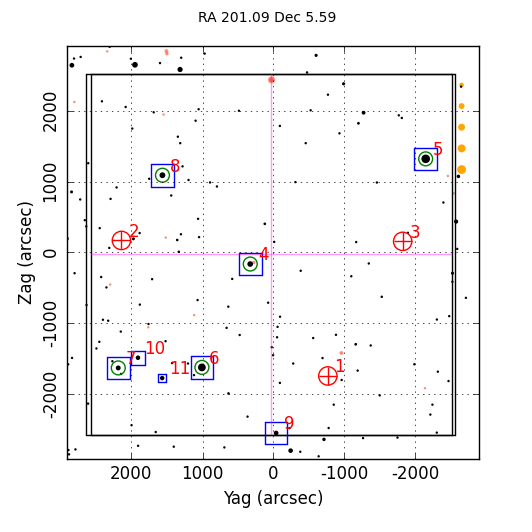

In [19]:
(.834 - .528) / 2

0.15299999999999997

In [20]:
from mica.archive import asp_l1

In [21]:
obs_files = asp_l1.get_files(22575)

In [38]:
asol = asp_l1.get_files(22575, content='ASPSOL')[0]
acen = asp_l1.get_files(22575, content='ACACENT')[0]

In [73]:
dat = QTable.read(acen)
dat['ang_y'] = dat['ang_y'].to('arcsec')
dat['ang_z'] = dat['ang_z'].to('arcsec')

In [74]:
dat.colnames

['time',
 'slot',
 'alg',
 'cent_i',
 'cent_j',
 'ang_y',
 'ang_z',
 'ang_y_sm',
 'ang_z_sm',
 'counts',
 'bkg',
 'chisq',
 'status']

In [79]:
ok = (dat['slot'] == 1) & (dat['alg'] == 8)
dok1 = dat[ok]
ok = (dat['slot'] == 2) & (dat['alg'] == 8)
dok2 = dat[ok]

In [81]:
dok1[-1]

<Row index=-1>
       time        slot  alg         cent_i             cent_j            ang_y             ang_z             ang_y_sm            ang_z_sm          counts      bkg    chisq  status
        s                             pix                pix              arcsec            arcsec              deg                 deg               ct         ct                 
     float64      uint8 uint8       float32            float32           float32           float32            float32             float32          float32    float32 float32 uint8 
----------------- ----- ----- ------------------- ----------------- ----------------- ------------------ ------------------ ------------------- ------------- ------- ------- ------
695992883.3145225     1     8 -425.25592041015625 37.36603546142578 2146.283935546875 167.02342224121094 0.5962199568748474 0.04638426750898361 162883.921875     0.0 433.744      0

In [82]:
dok2[-1]

<Row index=-1>
       time        slot  alg        cent_i             cent_j              ang_y              ang_z             ang_y_sm            ang_z_sm         counts      bkg    chisq  status
        s                            pix                pix                arcsec             arcsec              deg                 deg              ct         ct                 
     float64      uint8 uint8      float32            float32             float32            float32            float32             float32         float32    float32 float32 uint8 
----------------- ----- ----- ------------------ ------------------ ------------------- ----------------- ------------------- ------------------- ------------ ------- ------- ------
695992883.3145225     2     8 372.48126220703125 34.689735412597656 -1821.2022705078125 160.1657257080078 -0.5059361457824707 0.04447922110557556 170586.28125     0.0 418.947      0

In [131]:
y1_15, z1_15 = pixels_to_yagzag(dok1['cent_i'].value[-1], dok1['cent_j'].value[-1], coeff=coeffs_star, t_aca=15)
y2_15, z2_15 = pixels_to_yagzag(dok2['cent_i'].value[-1], dok2['cent_j'].value[-1], coeff=coeffs_star, t_aca=15)
y1_32, z1_32 = pixels_to_yagzag(dok1['cent_i'].value[-1], dok1['cent_j'].value[-1], coeff=coeffs_star, t_aca=32.2)
y2_32, z2_32 = pixels_to_yagzag(dok2['cent_i'].value[-1], dok2['cent_j'].value[-1], coeff=coeffs_star, t_aca=32.2)

In [124]:
(y2_32 - y1_32) - (y2_15 - y1_15)

1.8730145207332498

In [132]:
y1_15, z1_15 = pixels_to_yagzag(dok1['cent_i'].value[-1], dok1['cent_j'].value[-1], coeff=coeffs_new, t_aca=15)
y2_15, z2_15 = pixels_to_yagzag(dok2['cent_i'].value[-1], dok2['cent_j'].value[-1], coeff=coeffs_new, t_aca=15)
y1_32, z1_32 = pixels_to_yagzag(dok1['cent_i'].value[-1], dok1['cent_j'].value[-1], coeff=coeffs_new, t_aca=32.2)
y2_32, z2_32 = pixels_to_yagzag(dok2['cent_i'].value[-1], dok2['cent_j'].value[-1], coeff=coeffs_new, t_aca=32.2)
(y2_32 - y1_32) - (y2_15 - y1_15)

1.8730145274403185

In [259]:
def get_distances(obsid, coeffs, t_aca):
    acen = asp_l1.get_files(obsid, content='ACACENT')[0]
    dat = QTable.read(acen)
    # dat['ang_y'] = dat['ang_y'].to('arcsec')
    # dat['ang_z'] = dat['ang_z'].to('arcsec')
    dat = dat[(dat['alg'] == 8) & (dat['slot'] < 3)]
    d3 = dat[-3:]
    # d3['ang_y'] = d3['ang_y'].to_value('arcsec')
    # d3['ang_z'] = d3['ang_z'].to_value('arcsec')
    d3.sort('slot')
    d12s = []
    for ii, jj in ((0, 1), (0, 2), (1, 2)):
        f1 = d3[ii]
        f2 = d3[jj]
        y1, z1 = pixels_to_yagzag(f1['cent_i'], f1['cent_j'], coeff=coeffs, t_aca=t_aca)
        y2, z2 = pixels_to_yagzag(f2['cent_i'], f2['cent_j'], coeff=coeffs, t_aca=t_aca)
        d12 = dist(y1, z1, y2, z2)
        print(f'slot {ii}-{jj} dist={d12:.2f} arcsec')
        d12s.append(d12)
    return d12s

In [270]:
obs3996_dists = get_distances(3996, coeffs_new, 15)

slot 0-1 dist=3483.16 arcsec
slot 0-2 dist=2174.28 arcsec
slot 1-2 dist=3966.69 arcsec


In [271]:
obs22575_dists = get_distances(22575, coeffs_new, 32.3)

slot 0-1 dist=3482.55 arcsec
slot 0-2 dist=2174.53 arcsec
slot 1-2 dist=3966.62 arcsec


In [272]:
obs3996_dists = get_distances(3996, coeffs_caldb, 15)

slot 0-1 dist=3483.12 arcsec
slot 0-2 dist=2174.27 arcsec
slot 1-2 dist=3966.66 arcsec


In [273]:
obs22575_dists = get_distances(22575, coeffs_caldb, 32.3)

slot 0-1 dist=3483.89 arcsec
slot 0-2 dist=2174.25 arcsec
slot 1-2 dist=3967.51 arcsec


In [253]:
# 3996 is an observation in early 2004 with roughly zero delta-distance between ACIS-S 2 and 4 in yag/zag
# where delta-dist is change in distance from launch.
acen = asp_l1.get_files(3996, content='ACACENT')[0]
dat = QTable.read(acen)
dat['ang_y'] = dat['ang_y'].to('arcsec')
dat['ang_z'] = dat['ang_z'].to('arcsec')
dat = dat[(dat['alg'] == 8) & (dat['slot'] < 3)]
dat[-3:]

<QTable length=3>
       time        slot  alg        cent_i       ...   bkg    chisq  status
        s                            pix         ...    ct                 
     float64      uint8 uint8      float32       ... float32 float32 uint8 
----------------- ----- ----- ------------------ ... ------- ------- ------
208080457.5640286     2     8 370.82318115234375 ...     0.0 339.184      0
208080459.6140287     0     8 158.60256958007812 ...     0.0 342.026      0
208080459.6140287     1     8 -426.5541687011719 ...     0.0 307.373      0

In [98]:
# 22575 is an observation in early 2020 with roughly 1.4 arcsec delta-distance between ACIS-S 2 and 4 in yag/zag
# where delta-dist is change in distance from launch.
acen = asp_l1.get_files(22575, content='ACACENT')[0]
dat = QTable.read(acen)
dat['ang_y'] = dat['ang_y'].to('arcsec')
dat['ang_z'] = dat['ang_z'].to('arcsec')
dat = dat[(dat['alg'] == 8) & (dat['slot'] < 3)]
dat[-3:]

<QTable length=3>
       time        slot  alg         cent_i       ...   bkg    chisq  status
        s                             pix         ...    ct                 
     float64      uint8 uint8       float32       ... float32 float32 uint8 
----------------- ----- ----- ------------------- ... ------- ------- ------
695992883.3145225     0     8  160.15528869628906 ...     0.0 366.685      0
695992883.3145225     1     8 -425.25592041015625 ...     0.0 433.744      0
695992883.3145225     2     8  372.48126220703125 ...     0.0 418.947      0

In [103]:
# Change in row (yag) separation from sep_2020 - sep_2004 in arcsec.
# This gives a positive value.
(372.4812 + 425.2559) * 5 - (370.823 + 426.554) * 5

1.8005000000007385

In [269]:
coeffs = coeffs_new
y1_15, z1_15 = pixels_to_yagzag(-426.554, 39.236, coeff=coeffs, t_aca=15)
y2_15, z2_15 = pixels_to_yagzag(370.82318115234375, 36.5014533996582, coeff=coeffs, t_aca=15)
y1_32, z1_32 = pixels_to_yagzag(-425.25592041015625, 37.36603546142578, coeff=coeffs, t_aca=32.2)
y2_32, z2_32 = pixels_to_yagzag(372.48126220703125, 34.689735412597656, coeff=coeffs, t_aca=32.2)
print((y2_32 - y1_32) - (y2_15 - y1_15))
print((z2_32 - z1_32) - (z2_15 - z1_15))
print(dist(y1_15, z1_15, y2_15, z2_15))
print(dist(y1_32, z1_32, y2_32, z2_32))

0.0559436749436
1.20768671769
3966.68758635
3966.62979567


In [268]:
y1_15, z1_15 = pixels_to_yagzag(-426.554, 39.236, coeff=coeffs_caldb, t_aca=15)
y2_15, z2_15 = pixels_to_yagzag(370.82318115234375, 36.5014533996582, coeff=coeffs_caldb, t_aca=15)
y1_32, z1_32 = pixels_to_yagzag(-425.25592041015625, 37.36603546142578, coeff=coeffs_caldb, t_aca=32.2)
y2_32, z2_32 = pixels_to_yagzag(372.48126220703125, 34.689735412597656, coeff=coeffs_caldb, t_aca=32.2)
print((y2_32 - y1_32) - (y2_15 - y1_15))
print((z2_32 - z1_32) - (z2_15 - z1_15))
print(dist(y1_15, z1_15, y2_15, z2_15))
print(dist(y1_32, z1_32, y2_32, z2_32))

-0.846216867369
-0.295554013235
3966.66053205
3967.50725278


In [106]:
print(pixels_to_yagzag(372.4812, 34.68, coeff=coeffs_new, t_aca=15))
print(pixels_to_yagzag(-425.25, 37.37, coeff=coeffs_new, t_aca=15))

(-1823.9834511619467, 151.31400774133243)
(2143.7481189867622, 157.82401154138483)


In [109]:
print(pixels_to_yagzag(372.4812, 34.68, coeff=coeffs_star, t_aca=32.2))
print(pixels_to_yagzag(-425.25, 37.37, coeff=coeffs_star, t_aca=32.2))

(-1823.1176894254806, 151.68208613531445)
(2142.7408810868001, 157.25714346877243)


In [108]:
(2142.69 + 1823.08) - (2143.75 + 1823.98)

-1.9600000000000364

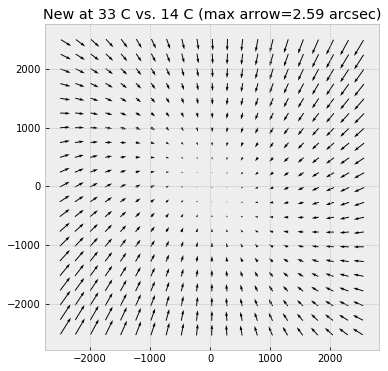

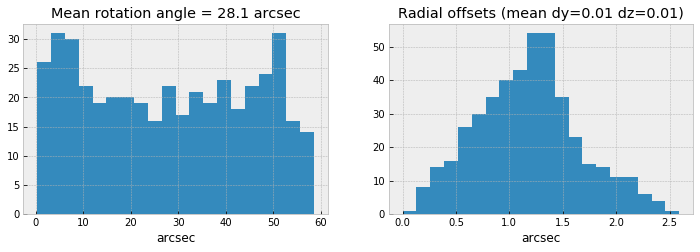

In [250]:
compare_coeffs_dashboard(coeffs1=coeffs_new, t_aca1=14, coeffs2=coeffs_new, t_aca2=33)

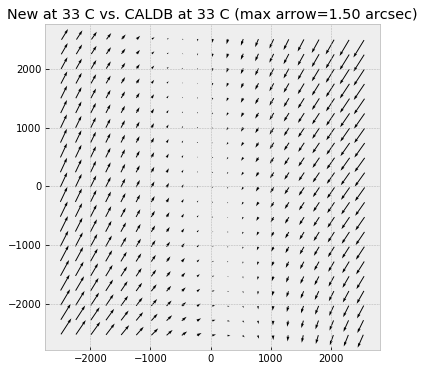

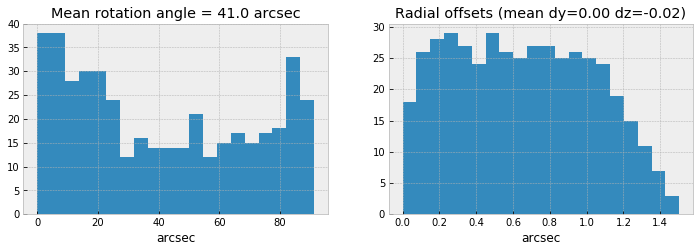

In [274]:
compare_coeffs_dashboard(coeffs1=coeffs_caldb, t_aca1=33, coeffs2=coeffs_new, t_aca2=33)

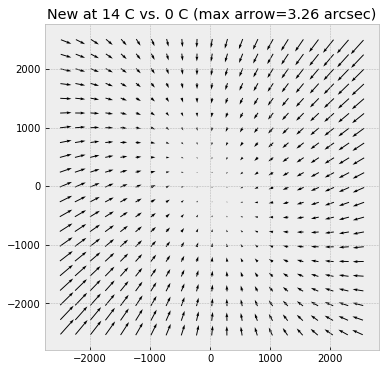

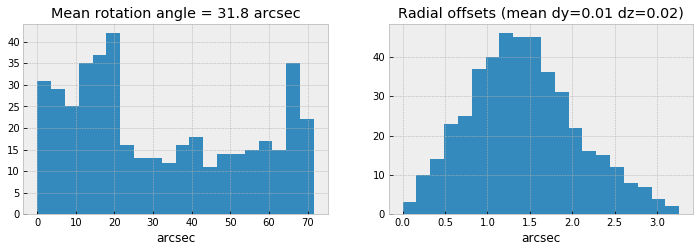

In [144]:
compare_coeffs_dashboard(coeffs1=coeffs_caldb, t_aca1=0, coeffs2=coeffs_caldb, t_aca2=14)

In [230]:
coeffs_caldb_0 = reparametrize_coeffs(coeffs_caldb.astype(np.float64), 14)
coeffs_caldb_1 = reparametrize_coeffs(coeffs_caldb_0, -14)
coeffs_caldb / coeffs_caldb_1

array([[  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [ nan,  nan],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [ nan,  nan],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.],
       [  1.,   1.]])

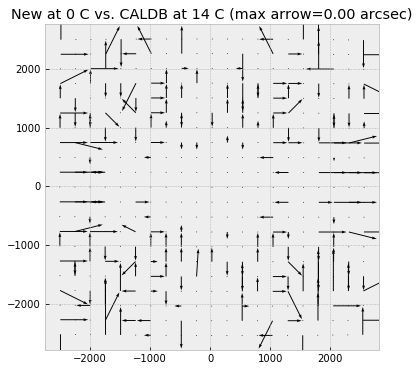

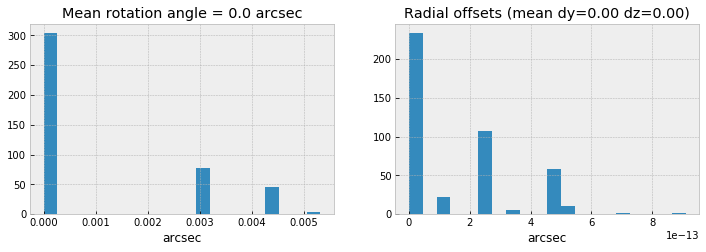

In [231]:
compare_coeffs_dashboard(coeffs1=coeffs_caldb, t_aca1=14, coeffs2=coeffs_caldb_0, t_aca2=0)

In [199]:
cs = np.zeros(shape=(19, 2))
cs[1, :] = [0, 1]
cs[2, :] = [1, 0]
cs[6, :] = [0, 0.1]
cs[8, :] = [0.1, 0]
cs /= 3600

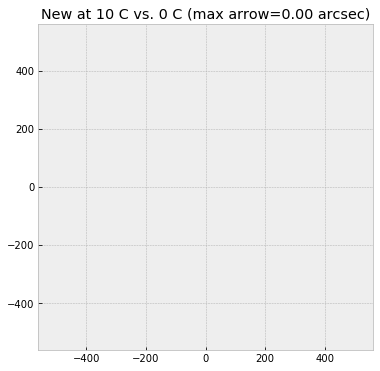

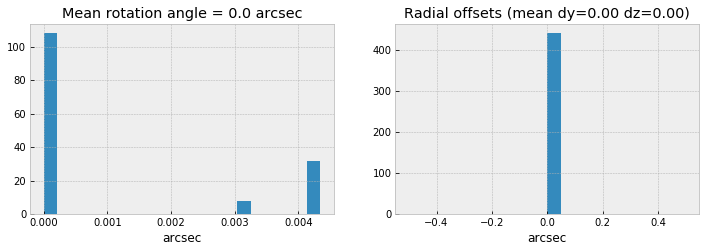

In [197]:
compare_coeffs_dashboard(coeffs1=cs, t_aca1=0, coeffs2=cs,t_aca2=10)

In [200]:
cs * 3600

array([[ 0. ,  0. ],
       [ 0. ,  1. ],
       [ 1. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0.1],
       [ 0. ,  0. ],
       [ 0.1,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ]])

In [208]:
print(pixels_to_yagzag(100, 200, coeff=cs, t_aca=0))
print(pixels_to_yagzag(100, 200, coeff=cs, t_aca=10))

(100.0, 200.0)
(200.0, 400.0)


In [209]:
cs2 = reparametrize_coeffs(cs, 10)

In [210]:
print(pixels_to_yagzag(100, 200, coeff=cs2, t_aca=0))
print(pixels_to_yagzag(100, 200, coeff=cs2, t_aca=10))

(200.0, 400.0)
(300.0, 600.0)


In [211]:
cs - cs2

array([[ 0.        ,  0.        ],
       [ 0.        , -0.00027778],
       [-0.00027778,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [275]:
coeffs_new

array([[  9.05777235e-03,  -4.22446104e-03],
       [  2.60135448e-06,   1.38731278e-03],
       [ -1.38789590e-03,   2.57928264e-06],
       [  0.00000000e+00,   0.00000000e+00],
       [ -1.06466391e-09,   7.83565268e-10],
       [ -1.03982778e-09,  -1.39266543e-10],
       [ -8.08320910e-11,  -3.87108301e-08],
       [ -1.20461385e-09,  -1.81896817e-10],
       [  4.29962199e-08,  -3.27306324e-08],
       [  0.00000000e+00,   0.00000000e+00],
       [ -1.02151001e-13,  -3.24393012e-11],
       [  3.26624006e-11,  -4.98327020e-13],
       [  3.29594707e-12,  -1.45179658e-12],
       [  2.24886001e-13,  -3.29556001e-11],
       [ -1.46631936e-12,  -1.67374079e-12],
       [  1.43836757e-11,  -8.59453828e-11],
       [  3.32276012e-11,   5.08828988e-14],
       [ -1.06374263e-12,   2.72769004e-12],
       [ -1.07588258e-10,   1.09572473e-09]], dtype=float32)

In [277]:
coeffs_new / coeffs_caldb

array([[ 1.        ,  1.        ],
       [ 0.9568693 ,  0.99980026],
       [ 0.99967289,  1.36618888],
       [        nan,         nan],
       [ 1.09397256,  1.11808038],
       [ 1.01680732,  0.92291838],
       [ 0.00578479,  0.56029493],
       [ 0.93571693,  1.19724882],
       [ 0.44479063, -0.64993703],
       [        nan,         nan],
       [ 1.        ,  1.        ],
       [ 1.        ,  1.        ],
       [-1.01835203, -0.32558212],
       [ 1.        ,  1.        ],
       [ 0.54428673,  1.98564136],
       [ 0.03521492, -0.12831672],
       [ 1.        ,  1.        ],
       [-0.21944557,  4.64578676],
       [ 0.06625749, -0.83513057]], dtype=float32)